# Python Visualization and Application 

In [3]:
import pandas as pd
from StandardCode import *
import numpy as np
import os
import re
import plotly.express as px

## build spark session

In [6]:
pysparkInit() # any function that can build the spark session 
thisCluster() # any function that can build the spark session 

queue='adhoc'
script='Test'
spark=sparkInit(queue=queue,script=script)

## parameter setting  

In [7]:
ora_user= 'your_schema' 
project = 'schema_pwd'
ora_server= 'ora_server'

CUSTOM_CONV_RPT_NM = 'report_name'

ora_host = 'ora_host'              
jdbc = 'driver'                      
real_server = 'ora_server'                   

## build required table:  Conversion Report 

In [10]:


query=f'''
a query to build CONV_RPT_NM
'''
execOracle(ora_user, project, ora_server,query)

## extract table from oracle to python df

In [11]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars ' + jdbc + ' pyspark-shell'
print(os.environ['PYSPARK_SUBMIT_ARGS'])


ORACLE_URL = "jdbc:oracle:thin:{}/{}@//{}/{}".format(ora_user, project, ora_host, server)

ret_df = spark.read.format('jdbc') \
    .option("fetchsize", 1000) \
    .option("driver", "oracle.jdbc.driver.OracleDriver") \
    .option("url", ORACLE_URL) \
    .option("dbtable", CUSTOM_CONV_RPT_NM)\
    .load()


target_df = ret_df.toPandas()


--jars ojdbc6.jar pyspark-shell


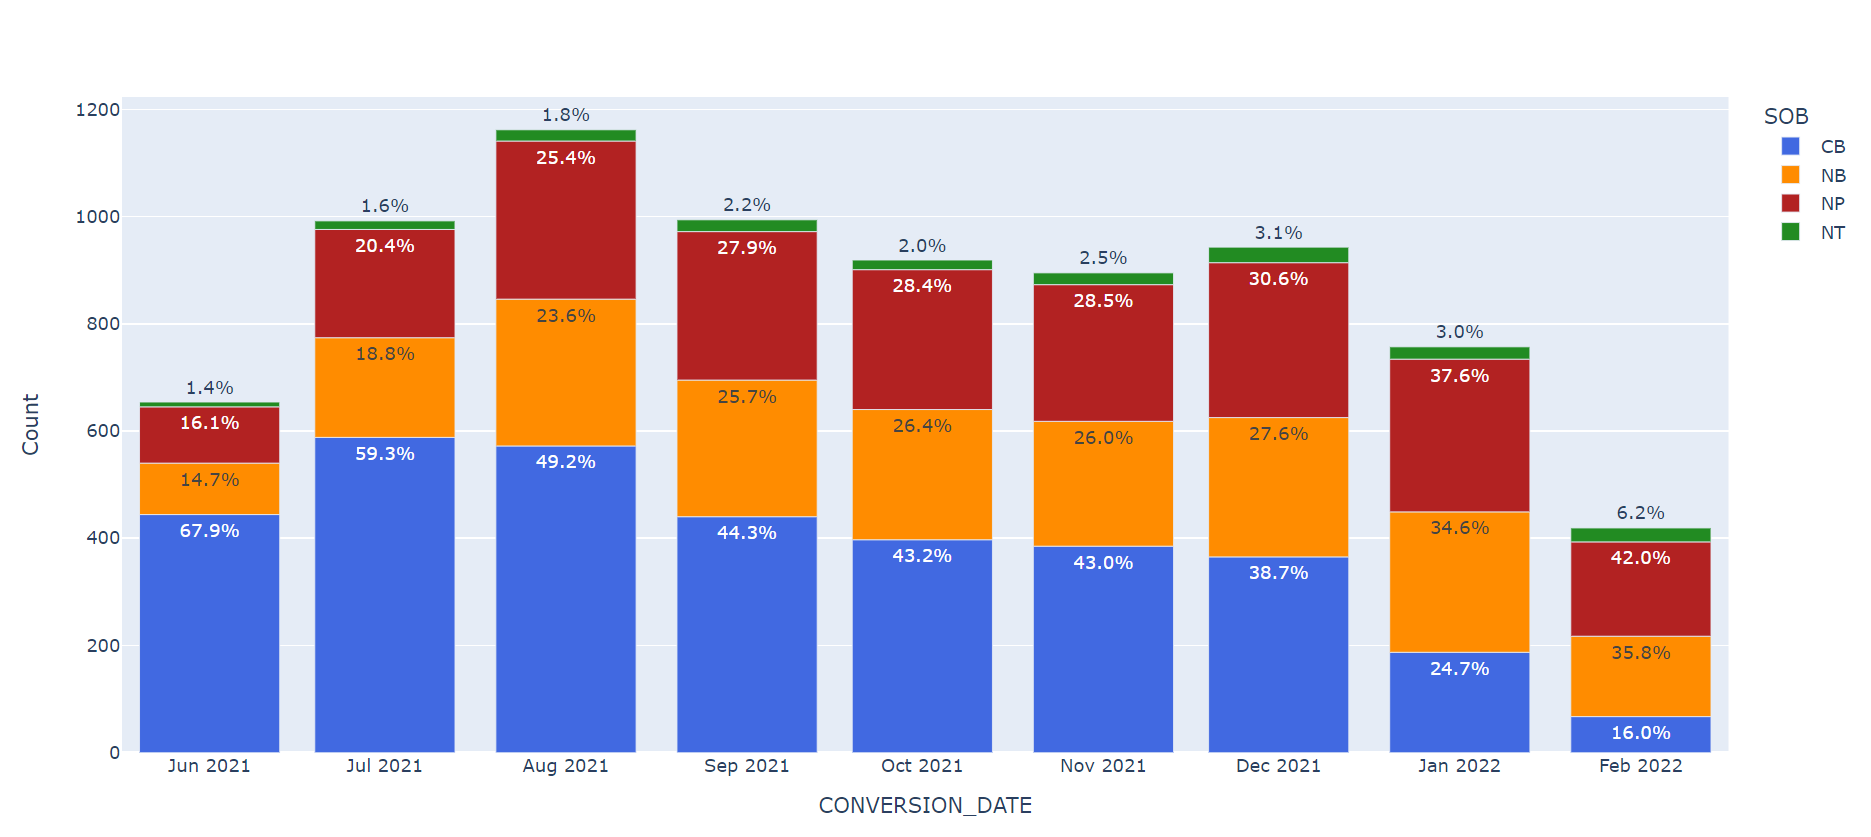

| Year_month | SOB | count | percent |
| :- | :- | :-: | :-: |
| Jun 2021 | CB | 5 | 50% |
| Jun 2021 | NB | 2 | 20% |
| Jun 2021 | NP | 2 | 20% |
| Jun 2021 | NT | 1 | 10% |
| Jul 2021 | CB | ... | ... |

In [ ]:
df_grouped = (
    target_df.groupby(
        # normalize all dates to start of month
        [target_df['CONVERSION_DATE'].astype('datetime64[M]'),'SOB']
    )['EXPOSURES_BEFORE_CONV'].count().rename('Count').to_frame()
)

df_grouped

In [33]:
df_grouped = df_grouped.reset_index()

In [ ]:
df_grouped['ratio'] = df_grouped['Count'] / df_grouped.groupby('CONVERSION_DATE')['Count'].transform('sum')*100
df_grouped['percent'] = df_grouped['ratio'].round(1).apply(str)+'%'
df_grouped

In [ ]:
fig1 = px.bar(df_grouped, x="CONVERSION_DATE", y="Count", color="SOB",text="percent",color_discrete_sequence=[
                 "RoyalBlue", "DarkOrange", "FireBrick", "ForestGreen"])


fig1.show()

## make more charts

In [95]:
def conversion_fig(ora_user, studyid, total_expo_nm):
    project = 'schema_pwd'
    ora_server= 'ora_server'
    study_id = str(studyid)
    CUSTOM_CONV_RPT_NM = 's'+study_id+'_CUSTOM_CONV_RPT_VIS'

    ora_host = 'ora_host'  
    jdbc = 'driver'                      
    real_server = 'ora_server'   

    query=f'''
    a query to build CUSTOM_CONV_RPT_NM
    '''
    execOracle(ora_user, project, ora_server,query)
    
    ORACLE_URL = "jdbc:oracle:thin:{}/{}@//{}/{}".format(ora_user, project, ora_host, server)

    ret_df = spark.read.format('jdbc') \
        .option("fetchsize", 1000) \
        .option("driver", "oracle.jdbc.driver.OracleDriver") \
        .option("url", ORACLE_URL) \
        .option("dbtable", CUSTOM_CONV_RPT_NM)\
        .load()


    target_df = ret_df.toPandas()
    
#     print(target_df)
    df_grouped = (
    target_df.groupby(
        # normalize all dates to start of month
        [target_df['CONVERSION_DATE'].astype('datetime64[M]'),'SOB']
    )['EXPOSURES_BEFORE_CONV'].count().rename('Count').to_frame()
    )
    df_grouped = df_grouped.reset_index()
    df_grouped['ratio'] = df_grouped['Count'] / df_grouped.groupby('CONVERSION_DATE')['Count'].transform('sum')*100
    df_grouped['percent'] = df_grouped['ratio'].round(1).apply(str)+'%'
    fig1 = px.bar(df_grouped, x="CONVERSION_DATE", y="Count", color="SOB",text="percent",color_discrete_sequence=[
                 "RoyalBlue", "DarkOrange", "FireBrick", "ForestGreen"])
    fig1.show()
    
    query_table_cleaning = f'drop table {CUSTOM_CONV_RPT_NM} purge'
    execOracle(ora_user, project, ora_server,query_table_cleaning)
    
    